In [227]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pickle
import pmdarima as pm
import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [228]:
with open("pickle_df2.pickle", 'rb') as filename:
    pension_df = pickle.load(filename)

In [229]:
def acf_chart(x):
    pm.acf(x)
    pm.plot_acf(x)

In [230]:
df = pension_df

In [231]:
df = df[df["약식명"]=="현대차"]

In [232]:
df['period'] = pd.to_datetime(df["기준일자"])
df = df.rename(columns={"자격상실": "num"})
df.head()

,약식명,기준일자,직원수,신규취득,num,당월고지금액,평균소득월액,period
309,현대차,2021-01,68931,840,669,29962149120,4829652,2021-01-01
310,현대차,2021-02,68591,329,508,29803844080,4827948,2021-02-01
311,현대차,2021-03,68270,187,516,29669780500,4828830,2021-03-01
312,현대차,2021-04,68664,910,559,29730070240,4810877,2021-04-01
313,현대차,2021-05,68501,396,500,29639369740,4807613,2021-05-01


In [233]:
df = df[["period", "num"]]
df = df.set_index('period')

In [234]:
df.head(2)

,num
period,
2021-01-01,669
2021-02-01,508


In [235]:
df.isnull().sum()

num    0
dtype: int64

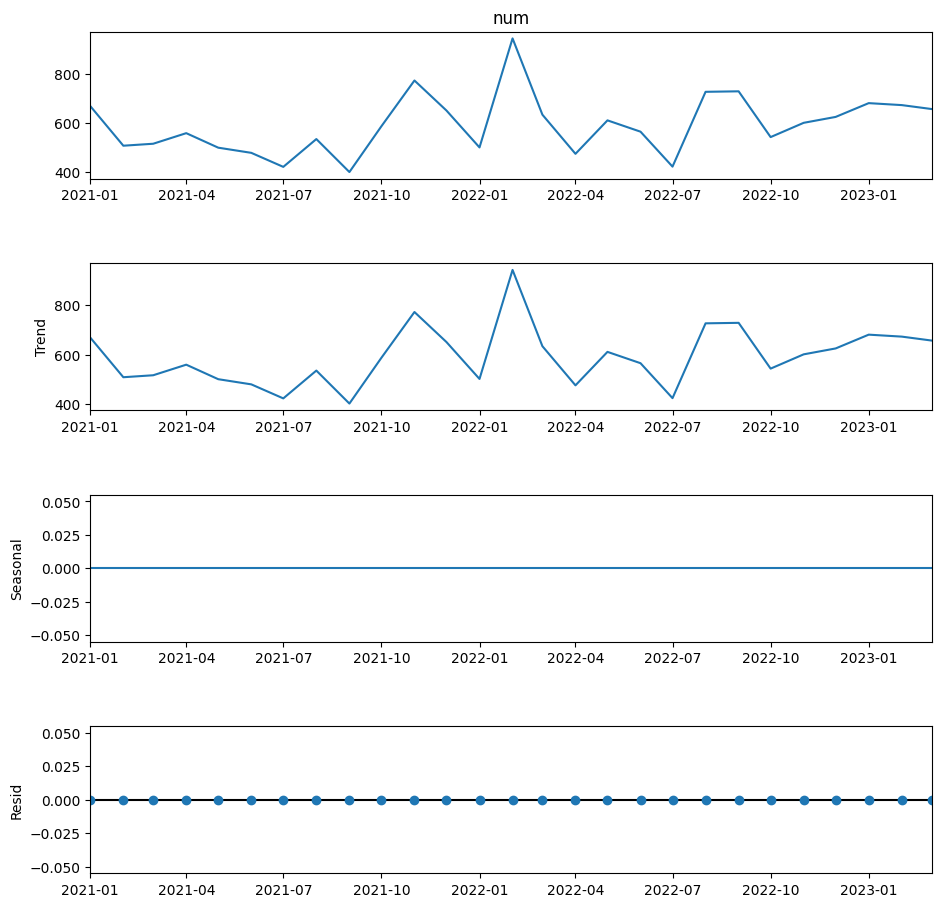

In [236]:
decomposition = sm.tsa.seasonal_decompose(df['num'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

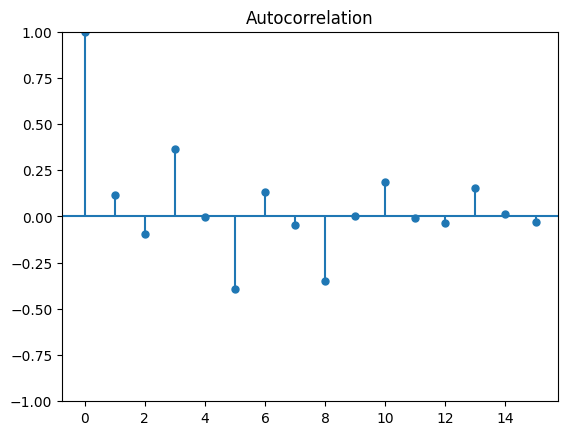

In [237]:
acf_chart(df['num'])

In [238]:
def tsplot(y, lags=12, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

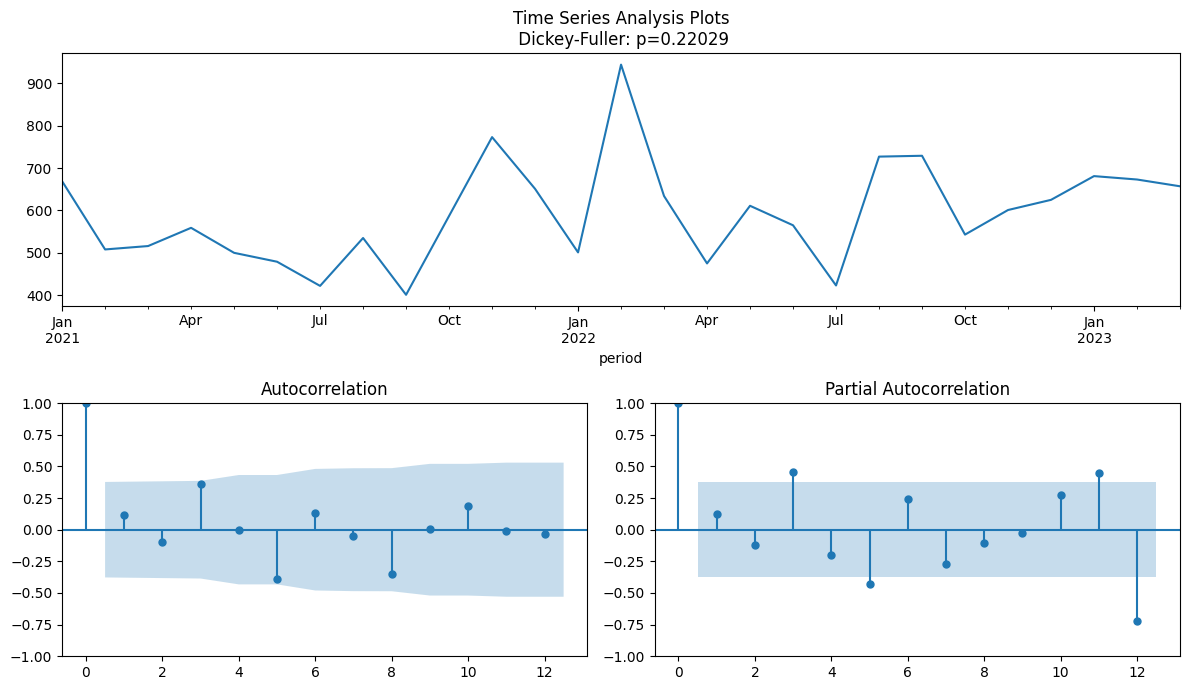

In [239]:
tsplot(df['num'])

In [240]:
adfuller(df['num'])

(-2.16208282416606,
 0.22029377723290006,
 4,
 22,
 {'1%': -3.769732625845229,
  '5%': -3.005425537190083,
  '10%': -2.6425009917355373},
 211.13632208226878)

In [241]:
y1_diff = df.diff().dropna()['num']   #diff의 디폴트 차분차수는 1이고.. 차분시 발생하는 짝이 없어서 발생하는 nan 데이터는 드랍한다.
y1_diff

period
2021-02-01   -161.0
2021-03-01      8.0
2021-04-01     43.0
2021-05-01    -59.0
2021-06-01    -21.0
2021-07-01    -57.0
2021-08-01    113.0
2021-09-01   -134.0
2021-10-01    186.0
2021-11-01    186.0
2021-12-01   -122.0
2022-01-01   -150.0
2022-02-01    443.0
2022-03-01   -310.0
2022-04-01   -159.0
2022-05-01    136.0
2022-06-01    -46.0
2022-07-01   -142.0
2022-08-01    304.0
2022-09-01      2.0
2022-10-01   -186.0
2022-11-01     58.0
2022-12-01     24.0
2023-01-01     56.0
2023-02-01     -8.0
2023-03-01    -16.0
Name: num, dtype: float64

In [242]:
adfuller(y1_diff)

(-8.092493854917606,
 1.36637824182356e-12,
 1,
 24,
 {'1%': -3.7377092158564813,
  '5%': -2.9922162731481485,
  '10%': -2.635746736111111},
 203.92412016440778)

In [243]:
# tsplot(y1_diff)

Augmented Dickey-Fuller Test
- adf : 검정통계량
- p value : 통상 p value가 0.05 보다 작아야 데이터가 stationary(움직이지 않는) 하다고 볼 수 있다.
- usedlag: 사용된 시차의 수
- nobs: 분석에 사용된 자료의 수
- critical values : 1%, 5%, 10% 수준에 해당되는 검정 통계량의 값

In [244]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [245]:
# Fit auto_arima function to dataset
stepwise_fit = auto_arima(df['num'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
# To print the summary
summary = stepwise_fit.summary()
summary

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=199.737, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=196.282, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=198.264, Time=0.59 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=196.338, Time=0.54 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=200.245, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=196.864, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 AR

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   27
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -95.141
Date:                              Fri, 28 Apr 2023   AIC                            196.282
Time:                                      08:46:35   BIC                            198.199
Sample:                                  01-01-2021   HQIC                           196.105
                                       - 03-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9974      0.035    -28.156      0.000      -1.067      -0.928
ma.S.L12       0.7807      1.501      0.520      0.603      -2.161       3.722
sigma2      6662.9629      0.000   2.81e+07      0.000    6662.962    6662.963
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.57   Prob(JB):                         0.90
Heteroskedasticity (H):               0.23   Skew:                             0.30
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.53e+23. Standard errors may be unstable.
"""

In [246]:
get_parametes = stepwise_fit.get_params()
get_parametes

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [247]:
order = get_parametes["order"]
seasonal_order = get_parametes["seasonal_order"]
order, seasonal_order

((0, 1, 0), (1, 1, 1, 12))

In [248]:
train = df.iloc[:24]
test = df.iloc[24:]

In [249]:
# train, test

In [250]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['num'], 
                order = order, 
                seasonal_order = seasonal_order)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  num   No. Observations:                   24
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -76.851
Date:                              Fri, 28 Apr 2023   AIC                            159.701
Time:                                      08:46:36   BIC                            160.895
Sample:                                  01-01-2021   HQIC                           158.949
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9808     32.164     -0.030      0.976     -64.022      62.060
ma.S.L12      -0.4489   1219.251     -0.000      1.000   -2390.138    2389.240
sigma2      1388.0610      1.128   1230.143      0.000    1385.849    1390.273
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.39   Prob(JB):                         0.75
Heteroskedasticity (H):               0.34   Skew:                             0.56
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.15e+21. Standard errors may be unstable.
"""

<AxesSubplot: xlabel='period'>

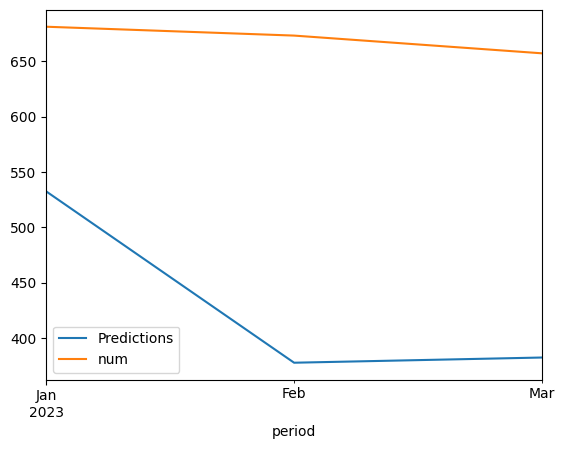

In [251]:
start = len(train)
end = len(train) + len(test) - 1
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
# plot predictions and actual values
predictions.plot(legend = True)
test['num'].plot(legend = True)

In [252]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Calculate root mean squared error
rmse(test["num"], predictions)
# Calculate mean squared error
mean_squared_error(test["num"], predictions)

61491.9555149961

<AxesSubplot: xlabel='period'>

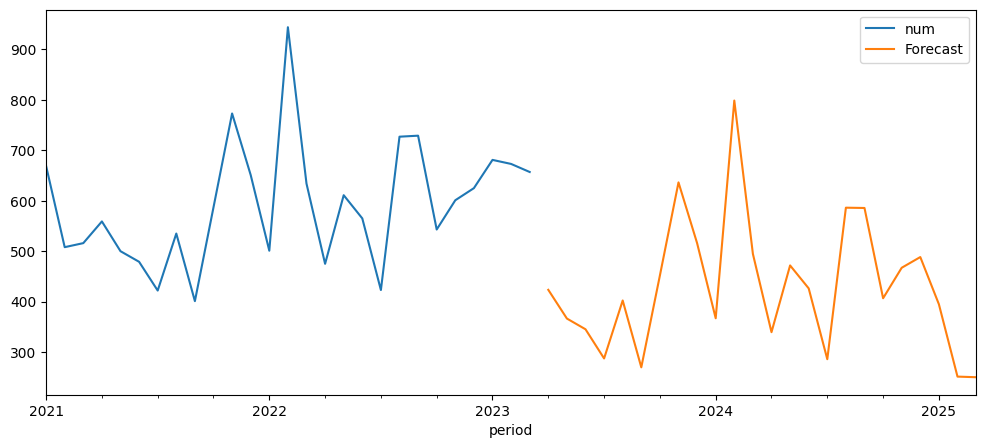

In [253]:
# Train the model on the full dataset
# model = SARIMAX(df['num'], order = order, seasonal_order =seasonal_order)
# result = model.fit()
# Forecast for the next 3 years
forecast = result.predict(start = len(df), 
                          end = (len(df)-1) + 2 * 12, 
                          typ = 'levels').rename('Forecast')
# Plot the forecast values
df['num'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

In [254]:
df['num']

period
2021-01-01    669
2021-02-01    508
2021-03-01    516
2021-04-01    559
2021-05-01    500
2021-06-01    479
2021-07-01    422
2021-08-01    535
2021-09-01    401
2021-10-01    587
2021-11-01    773
2021-12-01    651
2022-01-01    501
2022-02-01    944
2022-03-01    634
2022-04-01    475
2022-05-01    611
2022-06-01    565
2022-07-01    423
2022-08-01    727
2022-09-01    729
2022-10-01    543
2022-11-01    601
2022-12-01    625
2023-01-01    681
2023-02-01    673
2023-03-01    657
Name: num, dtype: int64

In [255]:
forecast.round()

2023-04-01    423.0
2023-05-01    366.0
2023-06-01    345.0
2023-07-01    287.0
2023-08-01    402.0
2023-09-01    270.0
2023-10-01    452.0
2023-11-01    636.0
2023-12-01    516.0
2024-01-01    367.0
2024-02-01    799.0
2024-03-01    495.0
2024-04-01    339.0
2024-05-01    472.0
2024-06-01    426.0
2024-07-01    286.0
2024-08-01    586.0
2024-09-01    586.0
2024-10-01    407.0
2024-11-01    467.0
2024-12-01    488.0
2025-01-01    395.0
2025-02-01    251.0
2025-03-01    250.0
Freq: MS, Name: Forecast, dtype: float64